## Introduction

Random walks are a fundamental concept in various scientific fields, including psychology, physics, biology, and economics. They serve as a versatile tool for modeling complex processes and phenomena. Markov chains, which are a generalization of random walks, find extensive applications in machine learning and Bayesian statistics. In essence, random walks serve as a foundational framework upon which many advanced algorithms are built.

### First steps from the [Qiskit tutorial](https://learn.qiskit.org/course/ch-algorithms/quantum-walk-search-algorithm)

On $\mathbb{Z}$: consider the integer line and let $j \in \mathbb{Z}$ and $|j \rangle$ be the position of the walker, now let the coin decide whether the walker moves in $|0 \rangle$ or in $| 1 \rangle$, representing the two directions on the line;

On a graph: a walk on a graph is described by two quantum states and two operators, we still consider examples from the case where the graph is simply $\mathbb{Z}$.

- **Position state**: it tells us the position of the walker, it was $| j \rangle$ in the example above;
- **Coin state**: it determines the next (in a discrete time) move of the walker.

Both states can be expressed in an Hilbert space, respectively $\mathcal{H}^P$ and $\mathcal{H}^C$, hence an element in  $\mathcal{H} = \mathcal{H}^P \otimes \mathcal{H}^C$ represents the whole state of the walker. The two operators are:

  - **Coin operator** ($C$): it acts on $\mathcal{H}^C$ and puts the walker in superposition;
  - **Shift operator** ($S$): it acts on $\mathcal{H}^P$ and moves the walker in the next position.

An example of a coin operator that we already know is the *Hadamard Gate* ($H$), a relevant alternative is the *Grover Diffusion Operator*, instead of giving the same probability to all possibilities, applying this operator to a state will give most probability for that state to remain and still give some equal probability to all the other possible states.

We can hence define a single step in a discrete time as the product $U = S \cdot C$. We can hence describe for a starting state $|{\psi(0)}\rangle$ the state at time $t$ as:  $|{\psi (t)}\rangle = U^t |{\psi(0)}\rangle$.
At this point it becomes easy to imagine how a random walk could be done on squares, cubes and hypercubes, generalised through the notion of the Cayley graph of the group $\mathbb{Z}_2^n$.

As an illustrative example, let's consider a square with four vertices labeled in binary form. We initiate our walk at vertex $00$. To simulate a random walk, we can employ a coin flip: if it lands heads (representing state 1), we execute the operation $\vec{x} \oplus 01$ (e.g., $00 \oplus 01$ if our initial state is $\vec{x}=00$). Conversely, for tails, we perform $\vec{x} \oplus 10$.


## QRW search algorithm: computational example

To provide a comprehensive demonstration of the quantum walk algorithm, we perform a detailed sample calculation for the case of $n=2$.

The primary objective of this subsection is to explicate the operational dynamics of the QRW search algorithm within a specific illustrative context. This random walk entails a traversal across an n-dimensional cube, and our focus herein will be to provide a comprehensive exposition of the events transpiring in the two-dimensional variant. We are going to consider a 2D hypercube (where $n=2$), constituting a representation of 4 ($2^{n}$) states within the state space denoted as $S$. It is important to note that transitions between states on the hypercube are characterized by one-bit flips. Thus, two-bit states are interlinked if the distinction between them lies in a single bit alteration (denoted as $|\vec{x} - \vec{y}| = 1$, wherein $\vec{x}$ and $\vec{y}$ represent bit strings). Within the formal context of our analysis, we introduce two distinct spaces: a coin space denoted as $C$ and the previously mentioned state space referred to as $S$. It is fundamental to underline that the direction of the walk across the states of this cube is governed by the characteristics of the coin space. Consequently, the coin state possesses a dimensionality of $n$, while the state space is characterized by a dimensionality of $2^{n}$. As a result, the algorithm's operation transpires within the Hilbert space denoted as $\mathcal{H}=\mathcal{H}^{C} \otimes \mathcal{H}^{S}$. The following figure provides a graphical representation of the mapping of the state space onto the hypercube.

Let's proceed to install and import all the requisite libraries for the specified tasks.

In [1]:
!pip install qiskit && pip install pylatexenc && pip install qiskit-aer && pip install qiskit-ibmq-provider

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136818 sha256=85de0bc77ab042a7bd56853257611ebd57abae2bd460d99787e7fd4e6bdade0b
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc
     ━━━━━━━━━━━━

In [2]:
# Useful imports
import numpy as np
import warnings

# Qiskit components
from qiskit import IBMQ
from qiskit import Aer, ClassicalRegister, QuantumRegister, QuantumCircuit, execute
from qiskit.quantum_info.operators import Operator
from qiskit.quantum_info import random_unitary
from qiskit.tools.monitor import backend_overview, backend_monitor

# Visualization
from qiskit.visualization import plot_histogram, plot_state_city
import matplotlib.pyplot as plt
import matplotlib.patches as patch
from matplotlib.path import Path
from matplotlib.animation import FuncAnimation
from IPython.display import Image

# Filter all warnings from now on
warnings.filterwarnings("ignore")


The following code is used to create a visual representation of a quantum random walk (QRW) on a 2D hypercube, as mentioned above.

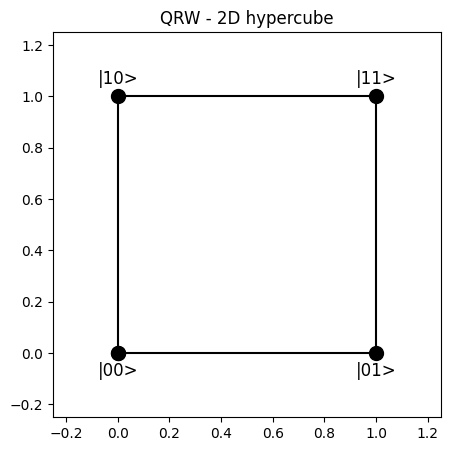

In [3]:
# Define the states
states = ['|00>', '|01>', '|11>', '|10>']
# Define the coordinates of the square's vertices
x = [0, 1, 1, 0, 0]
y = [0, 0, 1, 1, 0]
# Create a plot and set axis limits
plt.figure(figsize=(5, 5))
plt.plot(x, y, 'k-')
plt.scatter(x, y, c='black', s=100)
# Add text labels with variable offset
label_offset = 0.05
for i, state in enumerate(states):
    if i in [0, 1]:
        plt.text(x[i], y[i] - (1.8 * label_offset), state, fontsize=12, ha='center')
    elif i in [2, 3]:
        plt.text(x[i], y[i] + label_offset, state, fontsize=12, ha='center')
# Set axis limits and labels
plt.xlim(-0.25, 1.25)
plt.ylim(-0.25, 1.25)
# Add a title
plt.title('QRW - 2D hypercube')
# Show the plot
plt.grid(False)
plt.show()

In the following, we will proceed with the analysis on [Shenvi](https://arxiv.org/pdf/quant-ph/0210064v1.pdf) algorithm in the context specified above.

1. The initial phase entails the encoding of the quantum register's initialization, establishing a uniform superposition across all states, denoted as $|\psi_{0}\rangle = |s^{c}\rangle|s^{s}\rangle$. In a more general sense, $|s^{c}\rangle$ is defined as:

  $$
  |s^{c}\rangle = \frac{1}{\sqrt{n}} \sum_{d=1}^{n} |d\rangle
  $$

  In the context of our illustrative two-dimensional example, this corresponds to the subsequent state (as previously detailed in the paper):

  $$
  |s^{c}\rangle = \frac{1}{\sqrt{2}} \sum_{d=1}^{2} |d\rangle = \frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)
  $$

  Note that we have encoded the two directions as 0 and 1, rather than 1 and 2. As a consequence, we get the following result:

  \begin{align*}
  |\psi_{0}\rangle = (\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)) \: \otimes \: (\frac{1}{2}(|00\rangle + |01\rangle + |10\rangle + |11\rangle)) &= \frac{1}{2\sqrt{2}}(|000\rangle + |001\rangle + |010\rangle + |011\rangle + |100\rangle + |101\rangle + |110\rangle + |111\rangle)
  \end{align*}

2. Subsequently, the unitary operator $U' = SC'$, where $S$ is defined as:

  $$
  S = \sum_{d=0}^{1} \sum_{\vec{x}}|d, \: \vec{x} \oplus \vec{e}_{d}\rangle\langle d, \: \vec{x}|
  $$

 Additionally, $C'$ can be explicited as follows:

 $$
 C' = C_{0} \otimes \mathcal{I} - (C_{1} - C_{0}) \otimes |{\vec{0}}\rangle\langle{\vec{0}}|$$

 This unitary operation will be iterated $\frac{\pi}{2\sqrt{2^{n}}}$ times. In our specific case, it corresponds to $\pi \simeq 3$ times;

3. In the final step, we conduct a measurement of the quantum registry in the $|d, \: \vec{x}\rangle$ basis.

Let's consider the expansion of $U'$ operator, as follows. Our goal is to simplify the latter as much as possible by transforming it into a form consisting only of outer products. We will focus on the conversion of the operator into this simplified representation. The latter can be derived from equation `8` in [Shenvi](https://arxiv.org/pdf/quant-ph/0210064v1.pdf) paper, and it is intended for searching the $|00\rangle$ state within the state space.

$$
U' = SC' = U - 2S(|S^{c}\rangle \langle S^{c}| \otimes |\vec{0}\rangle \langle \vec{0}|)
$$

Focusing on the outer product of the coin space in the second term:

$$
|S^{c}\rangle \langle S^{c}| = (\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle))(\frac{1}{\sqrt{2}}(\langle0| + \langle1|)) = \frac{1}{2}(|0\rangle \langle0| + |0\rangle \langle1| + |1\rangle \langle0| + |1\rangle \langle1|)
$$

The second term in the operator $U'$ can be explicited as follows.

$$
U' = U - 2S(\frac{1}{2}(|0\rangle \langle0| + |0\rangle \langle1| + |1\rangle \langle0| + |1\rangle \langle1|) \otimes (|00\rangle \langle00|)) = U - S(|000\rangle \langle000| + |000\rangle \langle100| + |100\rangle \langle000| + |100\rangle \langle100|)
$$

Let's further expand $S$ operator:

$$
S = \sum_{d=0}^{n-1} \sum_{\vec{x}} |d, \: \vec{x} \oplus \vec{e}_{d}\rangle \langle d, \: \vec{x}| = \sum_{\vec{x}} |0, \: \vec{x} \oplus \vec{e}_{0}\rangle \langle 0, \: \vec{x}| + \sum_{\vec{y}} |1, \: \vec{y} \oplus \vec{e}_{1}\rangle \langle 1, \: \vec{y}|
$$

When examining only a single summation along the $\vec{0}$ direction, we observe the following:

$$
\sum_{\vec{x}} |0, \: \vec{x} \oplus \vec{e}_{0}\rangle \langle 0, \: \vec{x}| = |0, \: 00 \oplus \vec{e}_{0}\rangle \langle 0, \: 00| + |0, \: 01 \oplus \vec{e}_{0}\rangle \langle 0, \: 01| + |0, \: 10 \oplus \vec{e}_{0}\rangle \langle 0, \: 10| + |0, \: 11 \oplus \vec{e}_{0}\rangle \langle 0, \: 11|
$$

where, we will let $\vec{e}_{i}$ correspond to a bit flip of the $2^{i}$ place of the $\vec{x}$ bit string. As a consequence, the following result can be derived:

$$
\sum_{\vec{x}} |0, \: \vec{x} \oplus \vec{e}_{0}\rangle \langle 0, \: \vec{x}| = |0, \: 01\rangle \langle 0, \: 00| + |0, \: 00\rangle \langle 0, \: 01| + |0, \: 11\rangle \langle 0, \: 10| + |0, \: 10\rangle \langle 0, \: 11|
$$

Similarly, we obtain the subsequent outcome:

\begin{align*}
\sum_{\vec{x}} |1, \: \vec{x} \oplus \vec{e}_{1}\rangle \langle 1, \: \vec{x}| = |1, \: 00 \oplus \vec{e}_{1}\rangle \langle 1, \: 00| + |1, \: 01 \oplus \vec{e}_{1}\rangle \langle 1, \: 01| + |1, \: 10 \oplus \vec{e}_{1}\rangle \langle 1, \: 10| + |1, \: 11 \oplus \vec{e}_{1}\rangle \langle 1, \: 11| = |1, \: 10\rangle \langle 1, \: 00| + |1, \: 11\rangle \langle 1, \: 01| + |1, \: 00\rangle \langle 1, \: 10| + |1, \: 01\rangle \langle 1, \: 11|
\end{align*}

Thus, $S$ can be expressed as:

$$
S = |001\rangle \langle000| + |000\rangle \langle001| + |011\rangle \langle010| + |010\rangle \langle011| + |110\rangle \langle100| + |111\rangle \langle101| + |100\rangle \langle110| + |101\rangle \langle111|
$$

Now, we can further simplify the second term of $U'$, recalling that:

$$
U' = U - S(|000\rangle \langle000| + |000\rangle \langle100| + |100\rangle \langle000| + |100\rangle \langle100|)
$$


In addition, only the outer products in $S$ that contain either $\langle000|$ or $\langle100|$ will remain, as this choice effectively marks (as expected) the state $|00\rangle$ within the state space. Consequently, the operator $U'$ takes the following form:

$$
U' = U - (|001\rangle \langle000| + |001\rangle \langle100| + |110\rangle \langle000| + |110\rangle \langle100|)
$$

Now, let's consider the simplification of the operator $U$, recalling that:

$$
U = SC = S(C_{0} \otimes \mathcal{I^{s}}) = S((2|s^{c}\rangle \langle s^{c}| - \mathcal{I^{c}}) \otimes \mathcal{I^{s}})
$$

where, $\mathcal{I^{s}}$ and $\mathcal{I^{c}}$ are defined as: $\mathcal{I^{s}} = |00\rangle \langle00| + |01\rangle \langle01| + |10\rangle \langle10| + |11\rangle \langle11|$ while $\mathcal{I^{c}} = |0\rangle \langle0| + |1\rangle \langle1|$. As we have previously computed $|S^{c} \rangle \langle S^{c}|$, we can now proceed to calculate the subsequent quantity.

$$
(2|s^{c}\rangle \langle s^{c}| - \mathcal{I^{c}}) = |0\rangle \langle0| - |0\rangle \langle0| + |0\rangle \langle1| + |1\rangle \langle0| + |1\rangle \langle1| - |1\rangle \langle1| = |0\rangle \langle1| + |1\rangle \langle0|
$$

Consequently, $U$ can be explicited as follows:

$$
U = S((|0\rangle \langle1| + |1\rangle \langle0|) \otimes \mathcal{I^{s}})
$$

As can be seen, we are making progress towards achieving a complete simplification of the operator $U'$. Now, let's consider $C = (|0\rangle \langle1| + |1\rangle \langle0|) \otimes \mathcal{I^{s}}$; the latter can be decomposed as follows.

$$
C = (|0\rangle \langle1| + |1\rangle \langle0|) \otimes (|00\rangle \langle00| + |01\rangle \langle01| + |10\rangle \langle10| + |11\rangle \langle11|) = |000\rangle \langle100| + |001\rangle \langle101| + |010\rangle \langle110| + |011\rangle \langle111| + |100\rangle \langle000| + |101\rangle \langle001| + |110\rangle \langle010| + |111\rangle \langle011|
$$

Now, by applying $S$ to $C$, we obtain the operator $U$ as:

$$
U = SC = |001\rangle \langle100| + |000\rangle \langle101| + |011\rangle \langle110| + |010\rangle \langle111| + |110\rangle \langle000| + |111\rangle \langle001| + |100\rangle \langle010| + |101\rangle \langle011|
$$

Our next objective is to integrate our outer product representation for $U$ in order to complete our derivation of $U'$.

$$
U' = U - (|001\rangle \langle000| + |001\rangle \langle100| + |110\rangle \langle000| + |110\rangle \langle100|) = |000\rangle \langle101| + |011\rangle \langle110| + |010\rangle \langle111| + |111\rangle \langle001| + |100\rangle \langle010| + |101\rangle \langle011| - (|001\rangle \langle000| + |110\rangle \langle100|)
$$

In the end, we have obtained the following expression for $U'$:

$$
U' = |000\rangle \langle101| + |011\rangle \langle110| + |010\rangle \langle111| + |111\rangle \langle001| + |100\rangle \langle010| + |101\rangle \langle011| - (|001\rangle \langle000| + |110\rangle \langle100|)
$$

#### First application of $U'$

Given the quantum register initially prepared in a uniform superposition state (achieved by applying n single-bit Hadamard operators to the $|000\rangle$ state), we can proceed to apply the operator $U'$ to the $|\psi_{0}\rangle$ state for the first time. Recalling that:

$$
|\psi_{0}\rangle = \frac{1}{2\sqrt{2}}(|000\rangle + |001\rangle + |010\rangle + |011\rangle + |100\rangle + |101\rangle + |110\rangle + |111\rangle)
$$

Hence, we can express the first operator application equation as:

$$
|\psi_{1}\rangle = U'|\psi_{0}\rangle = (|000\rangle \langle101| + |011\rangle \langle110| + |010\rangle \langle111| + |111\rangle \langle001| + |100\rangle \langle010| + |101\rangle \langle011| - |001\rangle \langle000| - |110\rangle \langle100|) |\psi_{0}\rangle
$$

Continuing with the calculations, we obtain the subsequent result:

$$
|\psi_{1}\rangle = \frac{1}{2\sqrt{2}}(|000\rangle \langle101|101\rangle + |011\rangle \langle110|110\rangle + |010\rangle \langle111|111\rangle + |111\rangle \langle001|001\rangle + |100\rangle \langle010|010\rangle + |101\rangle \langle011|011\rangle - |001\rangle \langle000|000\rangle - |110\rangle \langle100|100\rangle)
$$

At the end, we get $|\psi_{1}\rangle$ defined as:

$$
|\psi_{1}\rangle = |\psi_{0}\rangle - \frac{1}{\sqrt{2}}(|001\rangle + |110\rangle)
$$

#### Second application of $U'$

Let's examine the second application of $U'$ on $|\psi_{0}\rangle$ state. Recalling that:

$$
|\psi_{1}\rangle = |\psi_{0}\rangle - \frac{1}{\sqrt{2}}(|001\rangle + |110\rangle)
$$

Let's define $|\psi_{2}\rangle$ as the state resulting from the second application of the operator $U'$:

$$
|\psi_{2}\rangle = U'|\psi_{1}\rangle = U'(|\psi_{0}\rangle - \frac{1}{\sqrt{2}}(|001\rangle + |110\rangle)) = |\psi_{1}\rangle - U'(\frac{1}{\sqrt{2}}(|001\rangle + |110\rangle)) = |\psi_{1}\rangle - \frac{1}{\sqrt{2}}(|111\rangle + |011\rangle)
$$

At the conclusion of this procedure, we obtain the following result:

$$
|\psi_{2}\rangle = |\psi_{0}\rangle - \frac{1}{\sqrt{2}}(|001\rangle + |011\rangle + |110\rangle + |111\rangle)
$$


#### Third application of $U'$

Let's conclude our analysis considering the last application of $U'$ on the initial state. Recalling that:

$$
|\psi_{2}\rangle = |\psi_{0}\rangle - \frac{1}{\sqrt{2}}(|001\rangle + |011\rangle + |110\rangle + |111\rangle)
$$

Let's define $|\psi_{3}\rangle$ as the state resulting from the third application of the operator $U'$:

$$
|\psi_{3}\rangle = U'|\psi_{2}\rangle = U'(|\psi_{0}\rangle - \frac{1}{\sqrt{2}}(|001\rangle + |011\rangle + |110\rangle + |111\rangle)) = |\psi_{1}\rangle - \frac{1}{\sqrt{2}}(|111\rangle + |101\rangle + |011\rangle + |010\rangle) = |\psi_{0}\rangle - \frac{1}{\sqrt{2}}(|001\rangle + |110\rangle + |111\rangle + |101\rangle + |011\rangle + |010\rangle)
$$

Upon completing our examination, we get the subsequent result:

$$
|\psi_{3}\rangle = \frac{1}{2\sqrt{2}}(|000\rangle - |011\rangle - |010\rangle - |111\rangle + |100\rangle - |101\rangle - |001\rangle - |110\rangle)
$$

The outcome following the application of $U' \simeq 3$ times reveals that the states $|000\rangle$ and $|100\rangle$ (the marked states) exhibit a phase differential of $\pi$ radians with respect to the others. As a consequence, we have successfully achieved the desired goal we were seeking.






## QRW: operators & circuit representation

In this study, we employ Qiskit, a powerful quantum computing framework, to represent and simulate the essential operators involved in the quantum walk algorithm. These operators include the shift operator ($S$), the coin operator ($C$), and the final unitary evolution operator ($U$), all meticulously defined for the quantum walk problem.

To facilitate our quantum walk simulation, we initially define the matrices using the NumPy library, ensuring precision and control over the mathematical operations. Subsequently, we leverage the [Operator class in Qiskit](https://qiskit.org/documentation/stubs/qiskit.quantum_info.Operator.html) to translate these matrices into quantum operators, making them suitable for quantum circuit operations.

The quantum circuit is constructed in a systematic manner, integrating the shift and coin operators. We will use the [unitary method in Qiskit](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.unitary.html) to incorporate these unitary matrices into the circuit. The latter assembly ensures the faithful representation of the quantum walk algorithm.

As an illustrative case study, we consider the scenario with $n=2$. Below, we present the matrix representations for the key operators:

- **Shift operator ($S$)**: it governs the spatial transition of the quantum walk. It is defined as:

  $$
  S = \sum_{d=0}^{1} \sum_{\vec{x}}|d, \: \vec{x} \oplus \vec{e}_{d}\rangle\langle d, \: \vec{x}|
  $$

- **Coin operator ($C$)**: it introduces quantum coin operations. It can be expressed as:

  $$
  C = G \otimes \mathcal{I} - (G - \mathcal{I}) \otimes |\vec{0}\rangle\langle\vec{0}|
  $$
  
  where $G$ represents Grover's diffusion operator, and $|{0}\rangle$ serves as the target state of our oracle;

- **Unitary evolution operator ($U$)**: it is defined as the composition of the shift and coin operators: $U = S \cdot C$.




## QRW: a quick example of a quantum walk on a hypercube

In order to provide an example of a quantum walk we first need to define the space on which our walk will be done. For this reason we introduce the concept of a hypercube, an $n$-dimensional counterpart to the classical 3-dimensional cube. The hypercube with dimension $n$ has $N=2^n$ nodes which all have degree $n$ (meaning that each node is described by $n$ numbers). A very useful way of representing the nodes (this will be important later when we need to know the walker's location at any time) is to use an $n$-tuple of binary numbers. Furthermore we choose the way of numbering the nodes such that for each node, all the neighbouring nodes only differ by one binary number. It can also be useful to introduce the idea of Hamming distance of strings, where this distance basically just says in how many characters do the strings differ.
Here we can quickly look at the $n=3$ hypercube. If we take the node labeled $(000)$ then the neighbours will be $(001)$, $(010)$ and $(100)$ (we can also say that their Hamming distance is exactly 1). Here it will also come in handy to somehow label the edges. One simple way of doing that is to say that if two nodes differ in the $a$-th bit then the edge is labelled $a$.

  $$
    |a, \: {\vec{v}}\rangle, \: 0 \leq a \leq n-1, \: {\vec{v}} \in \{(00...00), \:(00...01), \: ..., \: (11...11)\}
  $$

Here we take the number $a$ to be the computational basis for the coin and follow the rule: if $a=0$ then the walker goes to the node which differs from the one he is currently on in the first binary value, if $a=1$ then the walker goes to the node which differs from the one he is on in the second binary value and so on. This is very useful because it means we can express the shift operator $S$ in the following way:

  $$
    S|a\rangle |{\vec{v}}\rangle = |a\rangle |{\vec{v}} \oplus {\vec{e}_a}\rangle
  $$

where we defined ${\vec{e}_a}$ to be the $n$-tuple where all the binary values are 0, except for the $a$-th entry where it is 1. This way we can now define the whole unitary operator $U := SG$, where $G$ is chosen to be the Grover coin, or more specifically the Grover diffusion operator, already mentioned above. For this quick example of a single walk on the hypercube we will use 6 qubits: 4 will represent the position of the walker (therefore the domain of the QRW here is the 4 dimensional hypercube) and 2 will be used for the coin, which is, as already mentioned, the Grover coin.

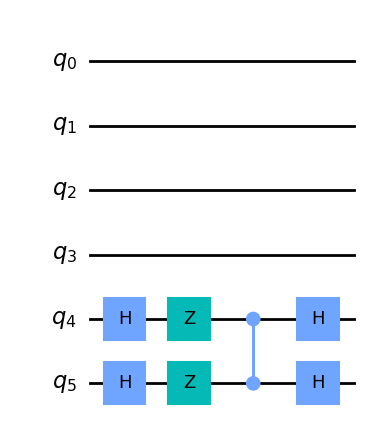

In [4]:
# 1 flip of the Grover coin
q = QuantumRegister(6, name='q') # 6 quantum bits, 2 for the coin, 4 for the hypercube
q_circ = QuantumCircuit(q)
for i in range(1):
    q_circ.h([4, 5])
    q_circ.z([4, 5])
    q_circ.cz(4, 5)
    q_circ.h([4, 5])
q_circ.draw('mpl')

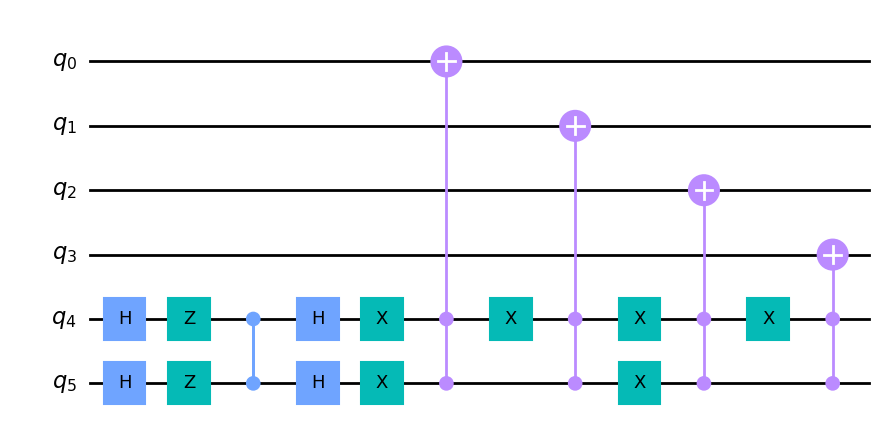

In [5]:
# 1 step in the process - a Grover coin toss and a shift operation
q = QuantumRegister(6, name='q') # same setup as before
q_circ = QuantumCircuit(q)
for i in range(1): # we are simulating one shift operation
    q_circ.h([4, 5])
    q_circ.z([4, 5])
    q_circ.cz(4, 5)
    q_circ.h([4, 5])
for i in range(0, 4): # here starts the shift operator, switching one of the four bits according to the rules mentioned above
    q_circ.x(4)
    if i % 2 == 0:
      q_circ.x(5)
    q_circ.ccx(4, 5, i)
q_circ.draw('mpl')

In the previous section a single step on the hypercube has been introduced, along with the appropriate code to visualize the Grover diffusion operator, as well as the shifting operator, which together constitute the unitary operator $U$.

Now, we can describe a more general situation where we want to find marked nodes on a hypercube, we will label this set with $M$. We start at an arbitrary node on the graph and move according to the walk until we get to one of the marked nodes. Here it is useful to have two quantum registers for the basis states, one  for the node that we are currently on and the other for the node we were on previously. Instead of the Grover coin and shift operator, here we are using the classical Markov chain with transition matrix $P$, of course defined as a unitary operator $W(P)$ acting on $\mathcal{H}$. We can now let $|x\rangle |y\rangle$ be a basis state, where $|x\rangle$ denotes the node we are on and $|y\rangle$ denotes some neighbouring node we can define as "prior". Now, we can define a basis state as "good" if $|x\rangle$ is one of the marked nodes and "bad" otherwise.

We can introduce a superposition over good states:

\begin{equation}
|G\rangle = \frac{1}{\sqrt{|M|}} \sum_{x \in M} |{x}\rangle |{p_x}\rangle
\end{equation}

and over bad states:

\begin{equation}
|{B}\rangle = \frac{1}{\sqrt{N-|M|}} \sum_{x \notin M} |{x}\rangle |{p_x}\rangle
\end{equation}

In order to fully describe the algorithm, we still need the following definitions, namely we define $\epsilon$ to be $\epsilon := |M|/N$ and $\theta := arcsin(\sqrt\epsilon)$.

Let's consider its full description as follows.

Firstly, we initialize the uniform superposition over all edges:

\begin{equation}
  |U\rangle = \frac{1}{\sqrt{N}}\sum_x|x\rangle|p_x\rangle = sin(\theta)|G\rangle + cos(\theta)|B\rangle
\end{equation}

This is a general first step with the random walk search algorithms, and is easily doable with Hadamard gates, as we have already shown more thoroughly on some previous examples.

The second step is repeated $O(\frac{1}{\sqrt\epsilon})$ times and is simply a reflection through $|B\rangle$ followed by a reflection through $|U\rangle$ which is extremely similar to the Grover algorithm for finding a desired state by reflecting around the unwanted superposition of states followed by a reflection around the original superposition, thus closing in on the desired superposition of states with every step of the algorithm.

Naturally, the third step is to perform a measurement in the computational basis which should give us one of the marked nodes with a high accuracy (depending on the number of times we have chosen to run the algorithm).

After this more abstract description of the algorithm, we will show the actual code implementation and how the algorithm realistically finds the desired state.

## QRW search algorithm implementation

The subsequent code defines a Python class `QRW_Reg` that initializes QRW registry for the search algorithm. The purpose of the following class is to configure the dimensions of the quantum circuit based on the input parameter `dim`, which represents the number of qubits in the state space.

In [6]:
# In this algorithm we have a dimension of n for the state space, then we have log_2(n) states in the coin space --> define the dimensions of the quantum circuit
class QRW_Reg:
    """
    QRW_Reg initializes a Quantum Random Walk registry --> it inputs the variable dim which is the number of qubits in the state space
    dim: number of qubits
    c: the number of coin qubits
    """
    def __init__(self, dim):
        c = (np.log2(dim))
        if c.is_integer() != 1:
            raise TypeError("The number of qubits n have to satisfy the condition that log_2(n) is an integer!")
        self.c = int(c)
        self.dim = dim
        n = int(dim + c)
        self.n = n
        q_r = QuantumRegister(n, 'q')
        cl_r = ClassicalRegister(n, "c")
        self.qr = q_r
        self.cl = cl_r
        q_circuit = QuantumCircuit(self.qr, self.cl)
        self.circuit = q_circuit

The following class encapsulates the quantum circuit and logic required to implement the QRW search algorithm based on the specified dimension and target state. It inherits from the `QRW_Reg` class and provides methods for defining operators and visualization, making it a comprehensive implementation of the QRW search algorithm.

In [7]:
# Define the QRW search algorithm as a subclass of the QRW registry
class QRW_Search(QRW_Reg):
    """
    QRW_Search is an implementation of the quantum random walk search algorithm
    based on the paper by N. Shenvi et alter (see References paragraph for more details).
    This class ineherits the QRW_Reg class
    dim: number of qubits in the state space
    state_search: the state that the algorithm searches for
    """
    def __init__(self, dim, state_search):
        QRW_Reg.__init__(self, dim)
        self.circuit = QRW_Reg(dim).circuit
        quantum_reg = QRW_Reg(dim).qr
        classical_reg = QRW_Reg(dim).cl
        self.search = state_search
        circ = self.circuit
        # Hadamards on all of the states
        circ.h(quantum_reg[0:self.n])
        # Operating U_prime pi/2 sqrt(2) times
        times = np.ceil(0.5 * np.pi * np.sqrt(2**(self.dim)))
        for i in range(int(times)):
            circ.unitary(self.U_prime(), quantum_reg, label="U'")
        # Measure the registry onto the classical bits
        circ.measure(quantum_reg, classical_reg)

    # Define all of the operators for the QRW search: S, C, U, U'

    def S(self, display_matrix=False):
        coin = self.c
        num_dir = int(2**coin)
        state = self.dim
        S = np.zeros((2**(coin + state), 2**(coin + state)))
        for i in range(num_dir):
          for j in range(2**state):
            # Perform the bit flip using a XOR
            j_bin = int(j)
            e_i = int(i + 1)
            xor = j_bin ^ e_i
            row = xor + (i * (2**state))
            S[row][j + (i * (2**state))] = 1
        if display_matrix:
          print('Matrix for the shift operator:')
          print(S)
        return Operator(S)

    def C(self, display_matrix=False):
        # Definition of the C operator as an outer product in the coin space --> tensor product with the identity in state space
        coin = self.c
        num_dir = int(2**coin)
        state = self.dim
        num_state = int(2**state)
        # Define the operator in just the coin space
        s_c = np.zeros((2**(coin), 2**(coin)))
        I_c = np.zeros((2**(coin), 2**(coin)))
        for i in range(num_dir):
            I_c[i][i] = 1
            for j in range(num_dir):
                s_c[i][j] = num_dir**(-1)
        s_c = 2 * s_c
        s_c = Operator(s_c)
        I_c = Operator(I_c)
        G = s_c - I_c
        # Define the identity in the state space
        I_s = np.zeros((2**(state), 2**(state)))
        for i in range(num_state):
            I_s[i][i] = 1
        I = Operator(I_s)
        C = G.tensor(I)
        if display_matrix:
            print('Matrix for the quantum coin operator:')
            print(np.real(C.data))
        return C

    def U(self, display_matrix=False):
        S_= self.S()
        C_ = self.C()
        U = C_.compose(S_)
        if display_matrix:
            print('Matrix for U:')
            print(np.real(U.data))
        return U

    def U_prime(self, display_matrix=False):
        # state_search is the state we are searching for --> focus on the second term
        # Note: the state search must be in decimal!
        if self.search >= 2**self.dim:
            raise TypeError("search_state parameter is outside of state space values.")
        elif self.search < 0:
            raise TypeError("search_state parameter is outside of state space values.")
        else:
            # Focus on the second term of U_prime
            coin = self.c
            num_dir = int(2**coin)
            state = self.dim
            num_state = int(2**state)
            search_array = np.zeros((num_state, num_state))
            search_array[self.search][self.search] = 1
            search = Operator(search_array)
            s_c = np.zeros((2**(coin), 2**(coin)))
            for i in range(num_dir):
                for j in range(num_dir):
                    s_c[i][j] = num_dir**(-1)
            coin_ = Operator(s_c)
            search_op = coin_.tensor(search)
            S_ = self.S()
            second_term = search_op.compose(S_)
            U_ = self.U()
            U_prime = U_ - (2 * second_term)
            if display_matrix:
                print("Matrix for U':")
                print(np.real(U_prime.data))
            return U_prime

    # Visualization
    def draw_circuit(self):
        return self.circuit.draw(output='mpl')

    # Plots by actually measuring the circuit
    def plot_states_hist(self):
        backend = Aer.get_backend('qasm_simulator')
        shots = 1024 # number of times circuit is run (for sampling)
        results = execute(self.circuit, backend=backend, shots=shots).result()
        counts = results.get_counts()
        return plot_histogram(counts, figsize=(5, 5), sort='value_desc')

The subsequent class is designed to encapsulate the quantum circuit and logic required to implement a QRW algorithm with the specified dimension, coin operator type, and number of steps. It inherits from the `QRW_Reg` class and provides methods for defining operators and for visualization and control of the QRW algorithm.

In [8]:
# Define the QRW algorithm as a subclass of the QRW registry
class QRW(QRW_Reg):
    """
    The QRW class is an arbitrary implementation of a QRW
    dim: number of qubits in the state space
    c_label: string that determines what coin operator to use on the coin space
    - hadamard = Hadamard operator --> tensor product with the identity
    - random = random unitary operator
    step: number of 'steps' the QRW completes which corresponds to the number of times the operator U is called
    """
    def __init__(self, dim, c_label, step):
        QRW_Reg.__init__(self, dim)
        self.circuit = QRW_Reg(dim).circuit
        quantum_reg = QRW_Reg(dim).qr
        classical_reg = QRW_Reg(dim).cl
        circ = self.circuit
        # Hadamards on all of the states
        circ.h(quantum_reg[0:self.n])
        for i in range(int(step)):
            circ.unitary(self.U(c_label), quantum_reg, label="step")
        # Measure the registry onto the classical bits
        circ.measure(quantum_reg, classical_reg)

    # Defining all of the operators for the QRW search: S, C, U

    def S(self):
        coin = self.c
        num_dir = int(2**coin)
        state = self.dim
        S = np.zeros((2**(coin + state), 2**(coin + state)))
        for i in range(num_dir):
            for j in range(2**state):
                # Perform the bit flip using a XOR
                j_bin = int(j)
                e_i = int(i + 1)
                xor = j_bin ^ e_i
                row = xor + (i * (2**state))
                S[row][j + (i * (2**state))] = 1
        return Operator(S)

    def C(self, c_label):
        coin = self.c
        state = self.dim
        # Create the identity in the S space
        I = np.zeros((2**state, 2**state))
        for i in range(2**state):
            I[i][i] = 1
        I = Operator(I)
        if c_label == "hadamard":
            result= np.zeros((2**coin, 2**coin))
            for i in range(2**coin):
                for j in range(2**coin):
                    if i >= 2 and j >= 2:
                        result[i][j] = (-1) * (-1)**(i * j) * (2**((-1) * (0.5 * coin)))
                    else:
                        result[i][j] = (-1)**(i * j) * (2**((-1) * (0.5 * coin)))
            res_op = (Operator(result))
            C_final = res_op.tensor(I)
            return C_final
        elif c_label == "random":
            dim = []
            for i in range(coin):
                dim.append(2)
            res_op = random_unitary(tuple(dim))
            C_final = res_op.tensor(I)
            return C_final
        else:
            raise TypeError("Label string for C is not a valid input!")

    def U(self, c_label):
        S_= self.S()
        C_ = self.C(c_label)
        U = C_.compose(S_)
        return U

    # Visualization
    def draw_circuit(self):
        return self.circuit.draw()

    # Plot by actually measuring the circuit
    def plot_states_hist(self):
        backend = Aer.get_backend('qasm_simulator')
        print(backend)
        shots = 1024 # number of times circuit is run (for sampling)
        results = execute(self.circuit, backend=backend, shots=shots).result()
        counts = results.get_counts()
        return plot_histogram(counts, figsize=(5, 5), sort='value_desc')

    # Control the circuit
    def execute(self):
        backend = Aer.get_backend('qasm_simulator')
        results = execute(self.circuit, backend=backend, shots=1).result()
        answer = results.get_counts()
        # One execution means that there will be one state in the answer dictionary
        state = list(answer.keys())
        return state[0]

Let's proceed with the explicit implementation.

In [9]:
# Define the QRW search circuit
search_circuit = QRW_Search(2, 2)


With the previously defined operators and concepts, we can proceed to construct a quantum circuit for the quantum random walk search problem, specifically for the case of $n=2$. This quantum walk problem is inspired by the work of [Shenvi](https://arxiv.org/pdf/quant-ph/0210064v1.pdf), who demonstrated a crucial result: after applying the unitary operator $U$ for a precise number of iterations, denoted as $t_{f}$, we attain the marked state with a certain probability.

The quantum circuit design for the quantum random walk search begins with the rigorous implementation of the unitary operator $U$. As detailed earlier, $U$ comprises a combination of the shift operator ($S$) and the coin operator ($C$). It is through the repeated application of this operator that we aim to locate the marked state within the quantum walk.

Shenvi's pioneering work provides a fundamental insight into the behavior of the quantum random walk search algorithm. Specifically, it establishes that after applying the unitary operator $U$ a total of $t_{f}$ times, where:

$$
t_{f} = \frac{\pi}{2} \sqrt{2^{n}}
$$

we achieve the marked state with a probability of $\frac{1}{2}-O\left(\frac{1}{n}\right)$.

In the specific case of $n=2$, our quantum random walk search algorithm involves the application of $U$ for a total of 4 times, corresponding to 4 discrete steps. This application aligns with Shenvi's result and is aimed at locating the marked state with the prescribed probability.

For further details on the circuit design, calculations, and implications of this quantum walk search problem, please refer to the comprehensive documentation and research provided by [Shenvi](https://arxiv.org/pdf/quant-ph/0210064v1.pdf).


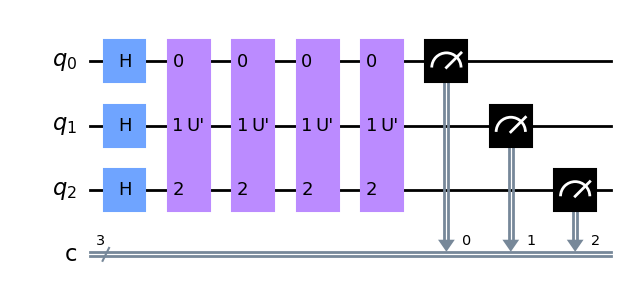

In [10]:
search_circuit.draw_circuit()

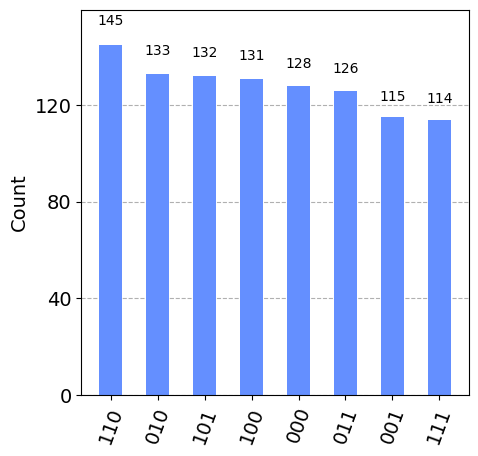

In [11]:
search_circuit.plot_states_hist()

In the pursuit of our quantum random walk, we have derived a sequence of quantum gates that can be implemented straightforwardly within the Qiskit framework. These gates enable us to orchestrate the quantum walk without the necessity of employing arbitrary operators, streamlining the implementation process.

For the sake of conciseness, we present the quantum circuit for a single iteration of the random walk. This circuit encapsulates the essential quantum gates required to advance the quantum walker through a single step of the walk.


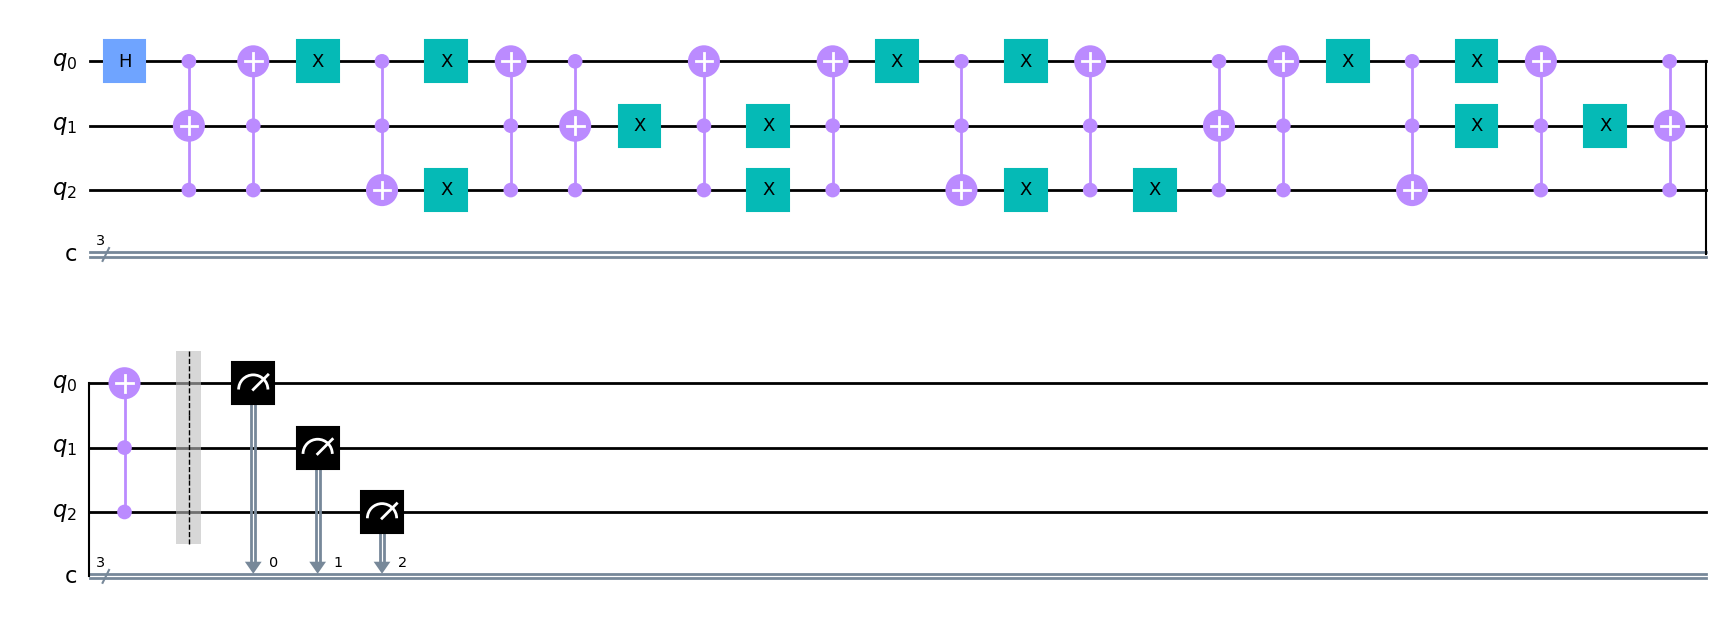

In [12]:
n_steps = 1
q = QuantumRegister(3, name='q') # 3 qubits register
c = ClassicalRegister(3, name='c') # 3 bits classical register
q_circ = QuantumCircuit(q, c) # quantum circuit
for i in range(n_steps):
    q_circ.h(0)
    q_circ.ccx(0, 2, 1)
    q_circ.ccx(1, 2, 0)
    q_circ.x(0)
    q_circ.ccx(0, 1, 2)
    q_circ.x(0)
    q_circ.x(2)
    q_circ.ccx(1, 2, 0)
    q_circ.ccx(0, 2, 1)
    q_circ.x(1)
    q_circ.ccx(1, 2, 0)
    q_circ.x(1)
    q_circ.x(2)
    q_circ.ccx(1, 2, 0)
    q_circ.x(0)
    q_circ.ccx(0, 1, 2)
    q_circ.x(0)
    q_circ.x(2)
    q_circ.ccx(1, 2, 0)
    q_circ.x(2)
    q_circ.ccx(0, 2, 1)
    q_circ.ccx(1, 2, 0)
    q_circ.x(0)
    q_circ.ccx(0, 1, 2)
    q_circ.x(0)
    q_circ.x(1)
    q_circ.ccx(1, 2, 0)
    q_circ.x(1)
    q_circ.ccx(0, 2, 1)
    q_circ.ccx(1, 2, 0)
q_circ.barrier()
q_circ.measure([q[0], q[1], q[2]], [c[0], c[1], c[2]])
q_circ.draw('mpl')

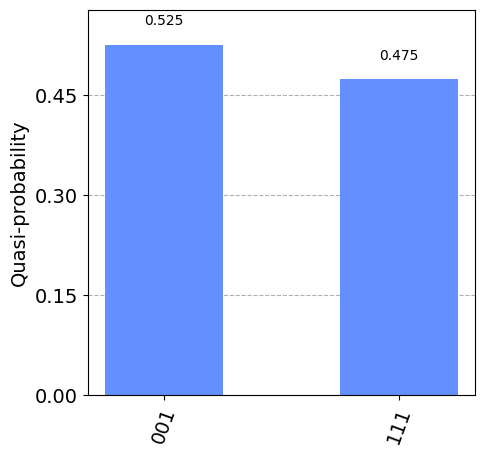

In [13]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024 # number of times circuit is run (for sampling)
results = execute(q_circ, backend=backend, shots=shots).result()
counts = results.get_counts()
# Normalize counts to obtain probabilities
total_counts = sum(counts.values())
probabilities = {state: count / total_counts for state, count in counts.items()}
plot_histogram(probabilities, figsize=(5, 5), sort='value_desc')

## Enhanced QRW search on the hypercube

In this context, we introduce an intriguing enhancement to the quantum random walk on the hypercube by imposing an additional requirement on the shift operator. Specifically, we assert that when the shift operator also 'flips' the state of the coin, i.e., when $S$ is defined as follows:

$$
S = \sum_{d=0}^{n-1} \sum_{\vec{x}}|d \: +(-1)^{\vec{x}}, \: \vec{x} \oplus \vec{e}_{d}\rangle\langle d, \: \vec{x}|
$$

This augmentation results in a quantum random walk that is not only simplified but remains highly accurate for the hypercube.

The concrete implementation of this enhanced quantum random walk on the hypercube is provided below. By incorporating this modification into the shift operator, we create a quantum walk that preserves the key characteristics of the original problem while offering increased simplicity and efficiency.

To substantiate the validity and effectiveness of this approach, we draw upon Shenvi's theorem, which provides essential insights into the behavior of quantum random walks. According to Shenvi's theorem, a precise number of iterations, denoted as $t_{f}$, is required to achieve specific outcomes in the quantum walk. In this case, we ascertain that:

$$
t_{f} = \frac{\pi}{2} \sqrt{2^{n}} = 4
$$

This calculation aligns with Shenvi's findings, indicating that our enhanced quantum random walk, with the modified shift operator, indeed attains its intended objectives in just 4 iterations. The integration of this enhancement promises a simplified yet potent approach to quantum random walks on hypercubes, offering a pathway for improved quantum algorithms and computational techniques.


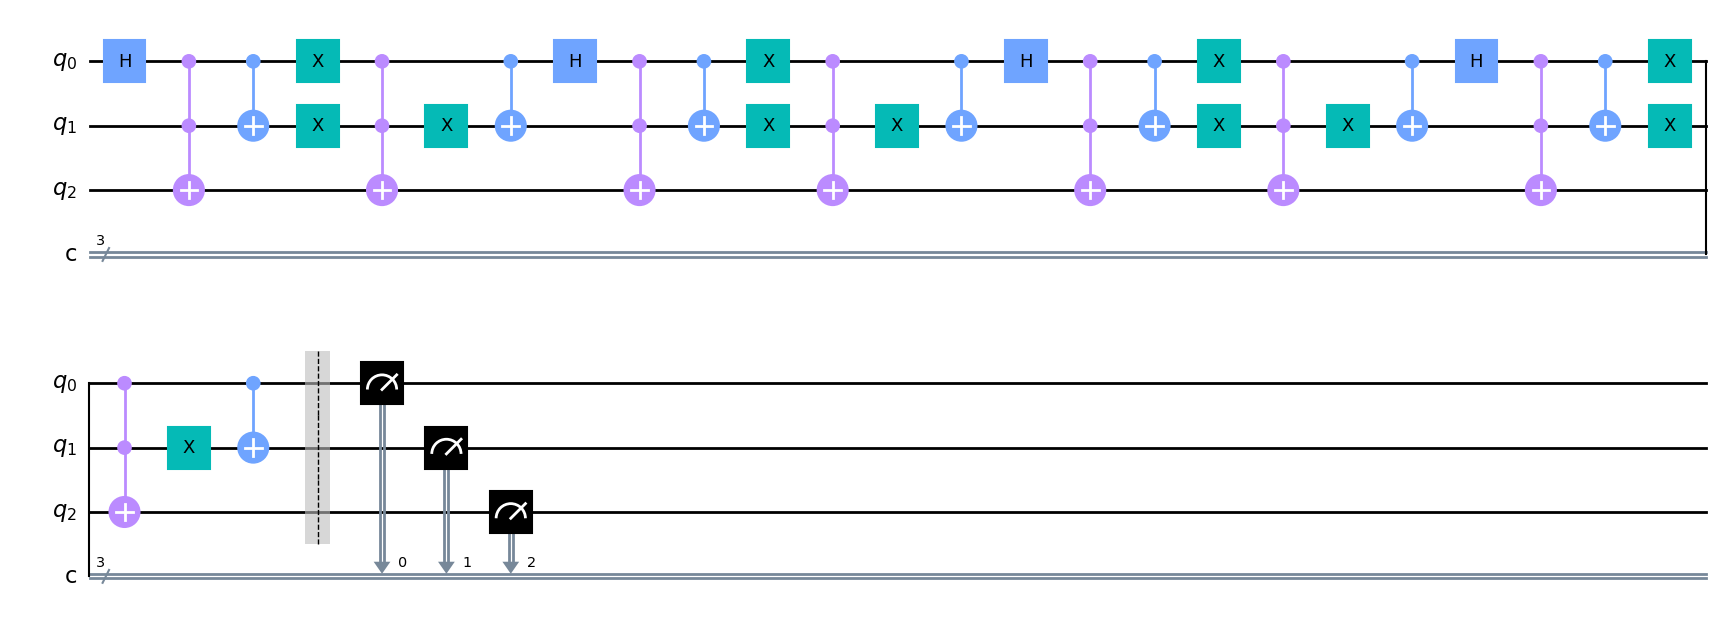

In [14]:
n_steps = 4
q = QuantumRegister(3, name='q') # 3 qubits register
c = ClassicalRegister(3, name='c') # 3 bits classical register
q_circ = QuantumCircuit(q, c) # quantum circuit
for i in range(n_steps):
    q_circ.h(q[0]) # coin
    q_circ.ccx(q[0], q[1], q[2]) # Toffoli
    q_circ.cx (q[0], q[1]) # CNOT
    q_circ.x(q[0])
    q_circ.x(q[1])
    q_circ.ccx(q[0], q[1], q[2])
    q_circ.x(q[1])
    q_circ.cx(q[0], q[1])
q_circ.barrier()
q_circ.measure([q[0], q[1], q[2]], [c[0], c[1], c[2]])
q_circ.draw('mpl')

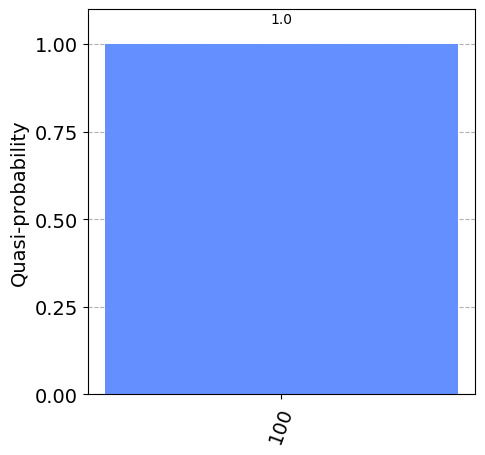

In [15]:
backend = Aer.get_backend('qasm_simulator')
shots = 1024 # number of times circuit is run (for sampling)
results = execute(q_circ, backend=backend, shots=shots).result()
counts = results.get_counts()
# Normalize counts to obtain probabilities
total_counts = sum(counts.values())
probabilities = {state: count / total_counts for state, count in counts.items()}
plot_histogram(probabilities, figsize=(5, 5), sort='value_desc')

## Execution on a real quantum computer

The QRW search algorithm can provide a quadratic speedup over classical algorithms in terms of query complexity. However, its practical implementation on real quantum hardware may be limited by the current state of quantum technology, including qubit quality, error rates, and the need for error correction.

The following code block initiates the process of establishing a connection to an actual IBM-provided quantum computer. It highlights the significance of executing `IBMQ.save_account()` just once to store your IBM Quantum account credentials, as rewriting them could cause problems. Following the account-saving step, the code loads the stored credentials and subsequently acquires information about the accessible quantum backends using the `backend_overview()` function.

In [17]:
# IBMQ.save_account needs to be run only once
IBMQ.save_account(API_KEY, overwrite=True)
# Load the saved IBMQ account
provider = IBMQ.load_account()
# Get a list of available backends
backend_overview()

ibm_brisbane                 ibm_perth                    ibm_nairobi
------------                 ---------                    -----------
Num. Qubits:  127            Num. Qubits:  7              Num. Qubits:  7
Pending Jobs: 108            Pending Jobs: 2660           Pending Jobs: 37
Least busy:   False          Least busy:   False          Least busy:   True
Operational:  True           Operational:  True           Operational:  True
Avg. T1:      232.5          Avg. T1:      138.5          Avg. T1:      98.7
Avg. T2:      145.4          Avg. T2:      114.7          Avg. T2:      76.6



ibm_lagos
---------
Num. Qubits:  7
Pending Jobs: 49
Least busy:   False
Operational:  True
Avg. T1:      110.8
Avg. T2:      77.2





Let's take into account a particular quantum computing device known as `ibm_brisbane`, which is a quantum computer equipped with **127** qubits. This means it offers a substantial amount of quantum computational capacity. The term `backend_device` also encompasses other essential characteristics of the quantum computer, including its architecture and operational specifications, all of which are pivotal for quantum algorithm development and research.

In [18]:
# Get a specific backend device by its name
backend_device = provider.get_backend('ibm_brisbane')
print("Running on: "+str(backend_device))

Running on: ibm_brisbane


In [19]:
# Monitor the status of the selected backend device
backend_monitor(backend_device)

ibm_brisbane
Configuration
-------------
    n_qubits: 127
    operational: True
    status_msg: active
    pending_jobs: 108
    backend_version: 1.1.6
    basis_gates: ['id', 'rz', 'sx', 'x', 'ecr', 'reset']
    local: False
    simulator: False
    qubit_lo_range: [[4.221884925043005, 5.221884925043005], [4.31513657301101, 5.31513657301101], [4.109672631450806, 5.109672631450806], [4.375618596297159, 5.375618596297159], [4.318133639381922, 5.318133639381922], [4.234156807591794, 5.234156807591794], [4.376229626698896, 5.376229626698896], [4.467499931137657, 5.467499931137657], [4.402393608826464, 5.402393608826464], [4.487232924677076, 5.487232924677076], [4.331532422016894, 5.331532422016894], [4.472284335555728, 5.472284335555728], [4.43631068787225, 5.43631068787225], [4.50580233921747, 5.50580233921747], [4.403347720671663, 5.403347720671663], [4.447927572346892, 5.447927572346892], [4.460304387692806, 5.460304387692806], [4.320802089305376, 5.320802089305376], [4.28825367512286

The subsequent code block then performs the execution on the chosen backend, retrieves measurement counts, calculates probabilities, and finally, plots a histogram for visual comparison between actual quantum computer results and simulated ones.

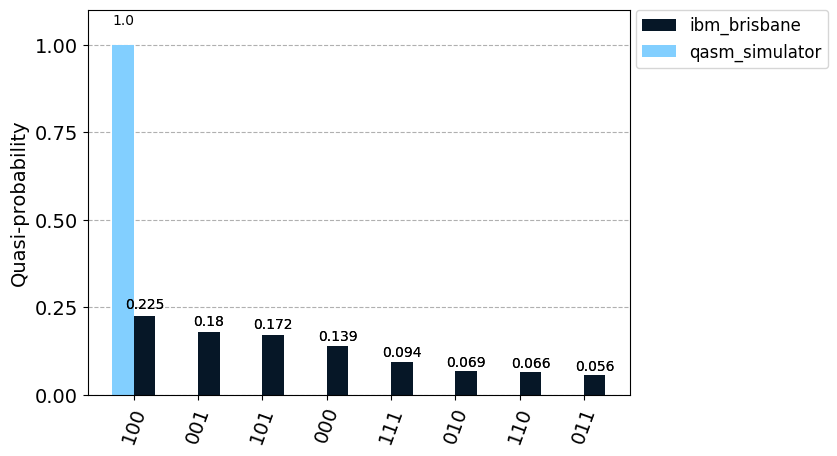

In [20]:
shots = 1024 # number of times circuit is run (for sampling)
# Execute the quantum circuit on the selected backend
results_r = execute(q_circ, backend_device, shots=shots).result()
counts_r = results_r.get_counts()
# Normalize counts to obtain probabilities
total_counts = sum(counts_r.values())
probabilities_r = {state: count_r / total_counts for state, count_r in counts_r.items()}
plot_histogram([probabilities_r, probabilities], legend=['ibm_brisbane', 'qasm_simulator'], color=['#061727', '#82cfff'], sort='value_desc')

The simulation results of our quantum algorithm exhibit a significant difference when compared to real quantum computer outcomes. Specifically, in the real quantum computer scenario, we observe a notable improvement in the probability of the desired state, which is twice as likely as any other state. In the simulation case, all other states would ideally have a probability of zero, whereas in the actual quantum computer results, they persist, though at reduced probabilities. It is also important to underline that, even in real quantum computers, the probability of our target state remains less than the ideal value. This disparity underscores the need for continued research and development to fill the gap between theoretical quantum algorithms and practical quantum hardware.

## QRW cellular automata

In addition to the direct quantum circuit implementation, we explore the utilization of the measured output from each step of the circuit to construct a quantum random walk cellular automata. This approach involves the mapping of both the state space and coin space of a quantum random walk onto a 2D mesh structure, enabling a more intuitive representation.

For this mapping, we correlate the measured states obtained from the quantum random walk circuit to specific positions within the 2D mesh. In this manner, we create a visual representation where the coin space serves to delineate larger regions, while the state space determines the characteristics of local squares within the mesh.

The resulting diagram, illustrated below, provides a visually insightful representation of the quantum random walk's behavior, highlighting the interplay between the coin and state spaces.




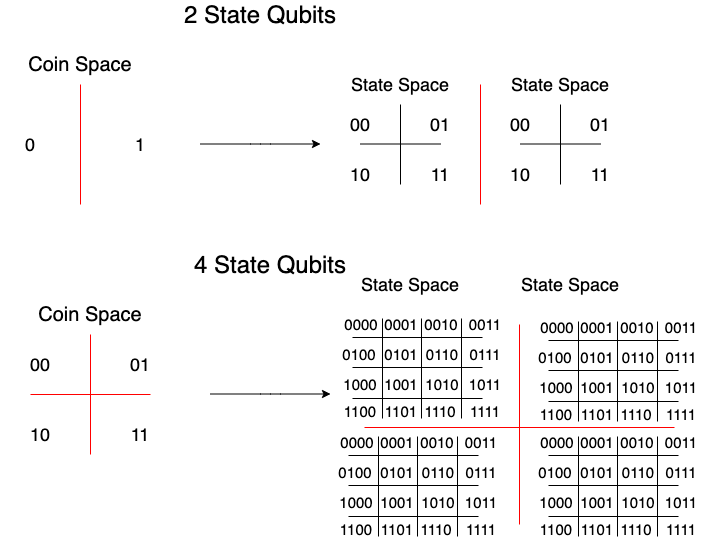

The following code defines a Python class named `QRW_Automata`, which is responsible for animating multiple executions of the Quantum Random Walk (QRW) algorithm into a cellular automata board.

In [21]:
# Animate the 2D 'mapping' for the QRW it inherits the QRW class
class QRW_Automata(QRW):
    """
    QRW_Automata is a class that inherits the QRW class --> it animates multiple executions of the QRW algorithm into a cellular automata board
    Note: this algorithm has only been defined for the cases of 2 and 4 state qubits!
    dim: number of qubits in the state space
    c_label: string that determines what coin operator to use on the coin space
    - hadamard = Hadamard operator --> tensor product with the identity
    - random = random unitary operator
    steps: number of 'steps' the QRW completes which corresponds to the number of times the operator U is called
    iters: number of times the circuit is executed (also determines the number of frames in the animation)
    """
    def __init__(self, dim, c_label, steps, iters):
        QRW.__init__(self, dim, c_label, steps)
        self.n = QRW(dim, c_label, steps).n
        self.c = QRW(dim, c_label, steps).c
        self.circ = QRW(dim, c_label, steps).circuit
        state = []
        for i in range(iters):
            state.append(QRW(dim, c_label, steps).execute())
        self.state = state
        print("State:")
        print(state)
        c_state = []
        s_state = []
        for i in state:
            c_state.append(i[0:self.c])
            s_state.append(i[self.c:])
        self.c_state = c_state
        self.s_state = s_state
        if (dim/2).is_integer() != True:
            raise ValueError("The half of the number of qubits in the state space has to be an integer!")
        # Divide up the board according to number of bits
        # n: number of rows and columns --> we are going to implement only the case for n=4!
        if int(self.dim) != 4 and int(self.dim) != 2:
            raise ValueError("Grid is implemented only for the cases where n=2 and n=4 in the state space!")
        figure, axes = plt.subplots(nrows=2, ncols=1)
        axes[0].set_facecolor((0, 0, 0))
        axes[0].get_xaxis().set_ticks([])
        axes[0].get_yaxis().set_ticks([])
        axes[1].get_xaxis().set_ticks([])
        axes[1].get_yaxis().set_ticks([])
        self.fig = figure
        self.ax = axes
        self.circuit.draw('mpl', scale=0.9, ax=axes[1])
        n_v = (2 * self.dim)
        if self.c % 2 != 0:
          n_h = self.dim
        else:
          n_h = n_v
        v_lines = np.arange(0, 1, 1/n_v)
        h_lines = np.arange(0, 1, 1/n_h)
        # Draw the frames for the board
        for i in v_lines:
            axes[0].axvline(x=i, ymin=0, ymax=1, color='r')
        for i in h_lines:
            axes[0].axhline(y=i, xmin=0, xmax=1, color='r')
        anim = FuncAnimation(self.fig, self.animate, frames=int(len(state)), interval=1300)
        anim.save("QRW_{n}qubits_{op}_{st}steps.gif".format(n=self.dim, op=c_label, st=steps),)

    def animate(self, i):
        # Plot the state space
        if self.dim == 2:
            c_ = self.c_state[i]
            s_ = self.s_state[i]
            n_v = (2 * self.dim)
            n_h = self.dim
            verts = [
                (0. + int(s_[-1]) * (1/n_v) + 0.5 * int(c_), 1. - int(s_[0]) * (1/n_h) - (1/n_h)), # left, bottom
                (0. + int(s_[-1]) * (1/n_v)+ 0.5 * int(c_), 1. - int(s_[0]) * (1/n_h)), # left, top
                ((1/n_v) + int(s_[-1]) * (1/n_v) + 0.5 * int(c_), 1. - int(s_[0]) * (1/n_h)), # right, top
                ((1/n_v) + int(s_[-1]) * (1/n_v) + 0.5 * int(c_), 1. - int(s_[0]) * (1/n_h) - (1/n_h)), # right, bottom
                (0. + int(s_[-1]) * (1/n_v) + 0.5 * int(c_), 1. - int(s_[0]) * (1/n_h) - (1/n_h)), # ignored
            ]
            codes = [
                Path.MOVETO,
                Path.LINETO,
                Path.LINETO,
                Path.LINETO,
                Path.CLOSEPOLY,
            ]
            path = Path(verts, codes)
            cell = patch.PathPatch(path, facecolor='w')
            self.ax[0].set_xlabel("Measured state: {state_}".format(state_=self.state[i]))
            self.ax[0].add_patch(cell)
            return patch
        elif self.dim == 4:
            c_ = self.c_state[i]
            s_ = self.s_state[i]
            n_v = (2 * self.dim)
            n_h = (2 * self.dim)
            verts = [
                (0. + int(s_[-1]) * (1/n_v) + int(s_[-2]) * (2/n_v) + 0.5 * int(c_[1]), 1. - int(s_[0])* 2 *(1/n_h) - int(s_[1]) * (1/n_h) - (1/n_h) - 0.5 * int(c_[0])), # left, bottom
                (0. + int(s_[-1]) * (1/n_v) + int(s_[-2]) * (2/n_v) + 0.5 * int(c_[1]), 1. - int(s_[0])* 2 *(1/n_h) - int(s_[1]) * (1/n_h) - 0.5 * int(c_[0])), # left, top
                ((1/n_v) + int(s_[-1]) * (1/n_v) + int(s_[-2]) * (2/n_v) + 0.5 * int(c_[1]), 1. - int(s_[0])* 2 *(1/n_h) - int(s_[1]) * (1/n_h) - 0.5 * int(c_[0])), # right, top
                ((1/n_v) + int(s_[-1]) * (1/n_v) + int(s_[-2]) * (2/n_v) + 0.5 * int(c_[1]), 1. - int(s_[0])* 2 *(1/n_h) - int(s_[1]) * (1/n_h) - (1/n_h) - 0.5 * int(c_[0])), # right, bottom
                (0. + int(s_[-1]) * (1/n_v) + int(s_[-2]) * (2/n_v) + 0.5 * int(c_[1]), 1. - int(s_[0])* 2 *(1/n_h) - int(s_[1]) * (1/n_h) - (1/n_h) - 0.5 * int(c_[0])), # ignored
            ]
            codes = [
                Path.MOVETO,
                Path.LINETO,
                Path.LINETO,
                Path.LINETO,
                Path.CLOSEPOLY,
            ]
            path = Path(verts, codes)
            cell = patch.PathPatch(path, facecolor='w')
            self.ax[0].set_xlabel("Measured state: {state_}".format(state_=self.state[i]))
            self.ax[0].add_patch(cell)
            return patch

Within our investigation, we explore the influence of different quantum coin operators on the quantum random walk's behavior. Specifically, we employ two distinct random coins: a Hadamard gate and an arbitrary random unitary operator

In the following, we will present the temporal evolution of the quantum walk for each of these quantum coin variants, accompanied by the corresponding quantum circuit, bearing titles that reflect the respective quantum coin operator.

**Hadamard quantum coin operator**: in one variant, we employ a Hadamard gate as the quantum coin operator. The evolution of the quantum walk over time is displayed below, showcasing the influence of this specific coin operator on the walker's trajectory.

State:
['010011', '011101', '101100', '100011', '010011', '111010', '111101', '011000', '000011', '011010', '011110', '000110', '001001', '101101', '011010', '111100']


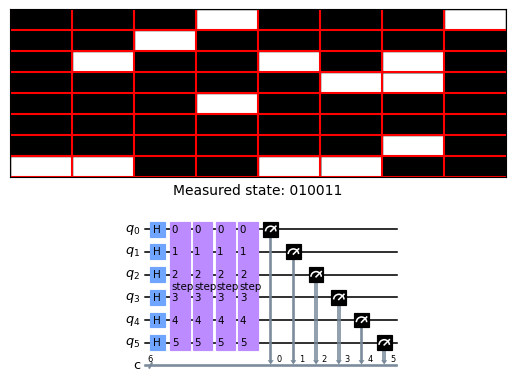

In [22]:
QRW_Automata(4, "hadamard", 4, 16)

**Arbitrary random unitary quantum coin operator**: in the second variant, we introduce an arbitrary random unitary operator as the quantum coin. This choice adds an element of unpredictability to the quantum walk's dynamics. The evolution of the quantum walk under this coin operator is presented below.

State:
['111100', '010010', '000100', '000000', '000110', '110101', '000101', '000000', '010110', '010110', '001011', '011110', '000001', '100000', '010111', '010111']


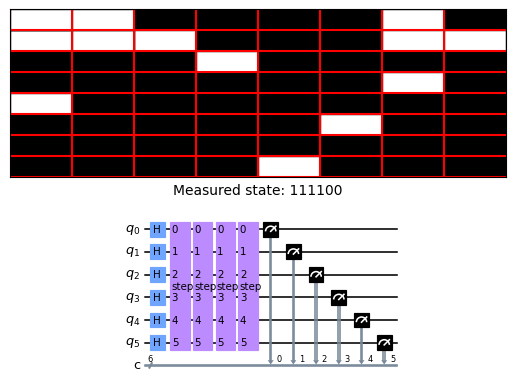

In [23]:
QRW_Automata(4, "random", 4, 16)

In the above outputs, it's possible to observe the final result at the conclusion of the measurements. Subsequently, we will instead consider the animation of the process explained earlier for the two cases under examination.

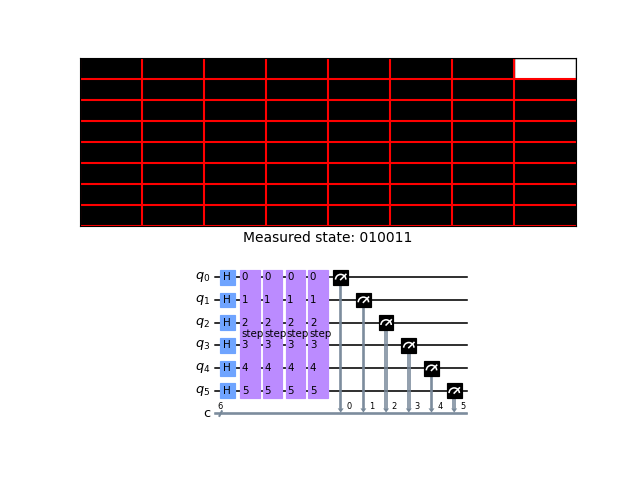

In [24]:
display(Image(data=open('/content/QRW_4qubits_hadamard_4steps.gif','rb').read(), format='gif'))

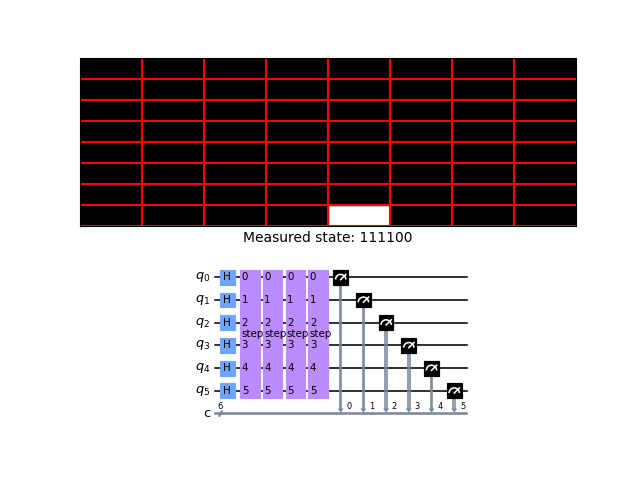

In [25]:
display(Image(data=open('/content/QRW_4qubits_random_4steps.gif','rb').read(), format='gif'))

## References

* Shenvi, N., Kempe, J., & Whaley, K. B. (2008). [*A Quantum Random Walk Search Algorithm*](https://arxiv.org/pdf/quant-ph/0210064v1.pdf). Departments of Chemistry and Computer Science, University of California, Berkeley, CA 94720, and CNRS-LRI, UMR 8623, Université de Paris-Sud, 91405 Orsay, France.
